In [22]:
# Задача
# 1. Сгенерируйте набор данных для предсказания временных последовательностей. Выполните тренировку RNN
# 2. Модифицируйте сеть, используя в качестве рекуррентного слоя LSTM слой библиотеки pytorch.
# https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
# 3. решите задачу набора данных лекции 7.

# Генерация синтетических данных

Обучение RNN
Эпоха [1/20], Потери: 0.1440
Эпоха [2/20], Потери: 0.0142
Эпоха [3/20], Потери: 0.0218
Эпоха [4/20], Потери: 0.0254
Эпоха [5/20], Потери: 0.0266
Эпоха [6/20], Потери: 0.0165
Эпоха [7/20], Потери: 0.0296
Эпоха [8/20], Потери: 0.0168
Эпоха [9/20], Потери: 0.0124
Эпоха [10/20], Потери: 0.0198
Эпоха [11/20], Потери: 0.0172
Эпоха [12/20], Потери: 0.0235
Эпоха [13/20], Потери: 0.0135
Эпоха [14/20], Потери: 0.0137
Эпоха [15/20], Потери: 0.0077
Эпоха [16/20], Потери: 0.0155
Эпоха [17/20], Потери: 0.0099
Эпоха [18/20], Потери: 0.0149
Эпоха [19/20], Потери: 0.0142
Эпоха [20/20], Потери: 0.0190
Обучение LSTM
Эпоха [1/20], Потери: 0.2662
Эпоха [2/20], Потери: 0.1222
Эпоха [3/20], Потери: 0.0147
Эпоха [4/20], Потери: 0.0151
Эпоха [5/20], Потери: 0.0228
Эпоха [6/20], Потери: 0.0183
Эпоха [7/20], Потери: 0.0163
Эпоха [8/20], Потери: 0.0088
Эпоха [9/20], Потери: 0.0132
Эпоха [10/20], Потери: 0.0151
Эпоха [11/20], Потери: 0.0105
Эпоха [12/20], Потери: 0.0142
Эпоха [13/20], Потери: 0.0126
Э

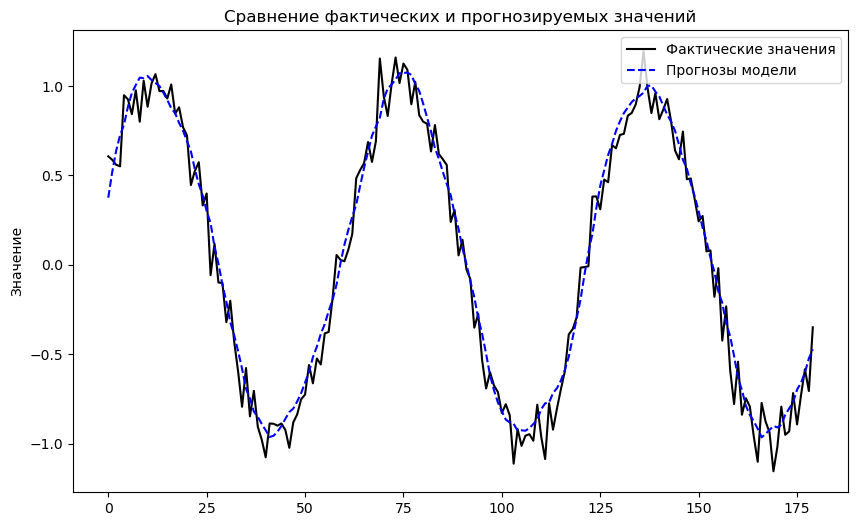

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Генерация набора данных временных последовательностей
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length]
        y = self.data[index + self.seq_length]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Определение модели RNN
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Модифицированная модель с LSTM
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Генерация синусоидальных данных с шумом
seq_length = 20
n_samples = 1000
x = np.linspace(0, 100, n_samples)
data = np.sin(x) + 0.1 * np.random.normal(size=len(x))  # Синусоида с шумом

# Разделение данных на тренировочный и тестовый наборы
train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Создание датасетов и загрузчиков данных
train_dataset = TimeSeriesDataset(train_data, seq_length)
test_dataset = TimeSeriesDataset(test_data, seq_length)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

input_size = 1
hidden_size = 50
output_size = 1

# Функция для обучения модели
def train_model(model, dataloader, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for batch_x, batch_y in dataloader:
            batch_x = batch_x.view(-1, seq_length, input_size)
            optimizer.zero_grad()
            output = model(batch_x)
            loss = criterion(output, batch_y.unsqueeze(1))
            loss.backward()
            optimizer.step()

        print(f"Эпоха [{epoch+1}/{epochs}], Потери: {loss.item():.4f}")

# Обучение RNN
print("Обучение RNN")
rnn_model = RNN(input_size, hidden_size, output_size)
train_model(rnn_model, train_dataloader, epochs=20)

# Обучение LSTM
print("Обучение LSTM")
lstm_model = LSTM(input_size, hidden_size, output_size)
train_model(lstm_model, train_dataloader, epochs=20)

# Проверка модели на тестовом наборе данных
model = lstm_model
model.eval()
predictions = []
actual = []

with torch.no_grad():
    for x, y in test_dataloader:
        x = x.view(1, seq_length, input_size)
        pred = model(x).item()
        predictions.append(pred)
        actual.append(y.item())

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.plot(actual, label="Фактические значения", linestyle='-', color='black')
plt.plot(predictions, label="Прогнозы модели", linestyle='--', color='blue')
plt.legend(loc='upper right')
plt.ylabel("Значение")
plt.title("Сравнение фактических и прогнозируемых значений")
plt.show()

In [26]:
# Разделить данные на N групп. (возможно, выбрать первые M данных для обучения)
# Реализовать предсказание ARIMA для 2 (тренировочной группы) на основе 1. Рассчитать MSE.
# Исследовать качество работы модели в зависимости от параметров (для групп 1-2).
# (1)Выполнить итеративное предсказание, данные для каждого следующего предсказания обновлять по методу
# "экспоненциальное среднее".

C:\Users\seva0\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\seva0\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\seva0\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE with Exponential Smoothing: 0.0263


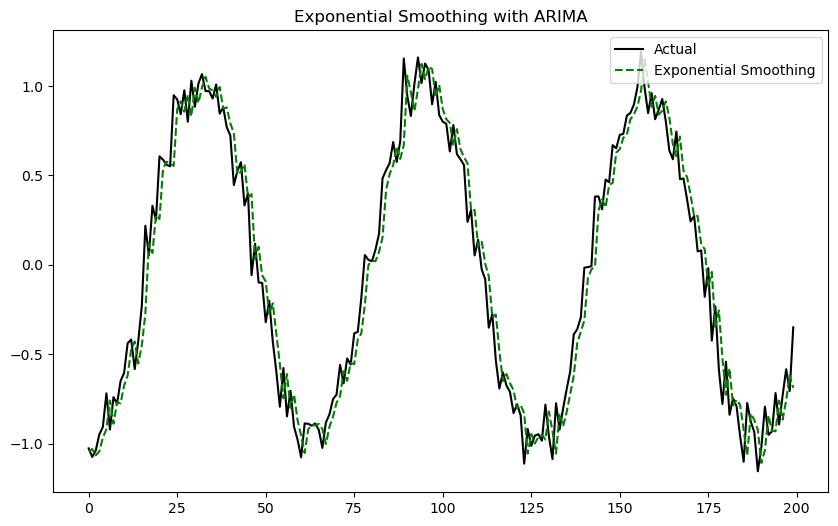

In [27]:
# ARIMA: Предсказание с экспоненциальным средним
train_values = train_data
forecast_steps = len(test_data)
alpha = 0.8

model_arima = ARIMA(train_values, order=(3, 1, 2)).fit()
arima_predictions = model_arima.forecast(steps=forecast_steps)

exp_smoothed_predictions = []
current_pred = arima_predictions[0]
for i, actual_value in enumerate(test_data):
    exp_smoothed_predictions.append(current_pred)
    current_pred = alpha * actual_value + (1 - alpha) * current_pred

mse_exp_smooth = mean_squared_error(test_data, exp_smoothed_predictions)
print(f"MSE with Exponential Smoothing: {mse_exp_smooth:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(test_data, label="Actual", color="black")
plt.plot(exp_smoothed_predictions, label="Exponential Smoothing", linestyle="--", color="green")
plt.legend()
plt.title("Exponential Smoothing with ARIMA")
plt.show()